- http://aicip.eecs.utk.edu/wiki/UTKFace

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from pathlib import Path

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def show_dct(dct, n=3):
    return list(dct.items())[:n]

In [3]:
from fastai import *
from fastai.vision import *

In [4]:
pdata = Path('/data/utkface/')

In [5]:
list(pdata.glob('*'))

[PosixPath('/data/utkface/UTKface_inthewild'),
 PosixPath('/data/utkface/UTKface_Aligned_cropped'),
 PosixPath('/data/utkface/Landmark'),
 PosixPath('/data/utkface/.DS_Store')]

## imgs

### UTKFace

In [6]:
# fns = list(pdata.glob('UTKface_inthewild/part*/*.jpg'))

fns = list(pdata.glob('UTKface_Aligned_cropped/UTKFace/*.jpg'))

len(fns)

23708

In [7]:
fns[:3]

[PosixPath('/data/utkface/UTKface_Aligned_cropped/UTKFace/35_1_0_20170117183059886.jpg.chip.jpg'),
 PosixPath('/data/utkface/UTKface_Aligned_cropped/UTKFace/30_0_0_20170117130638578.jpg.chip.jpg'),
 PosixPath('/data/utkface/UTKface_Aligned_cropped/UTKFace/18_1_0_20170109214453184.jpg.chip.jpg')]

In [8]:
fns = [fn for fn in fns if len(str(fn).split('/')[-1].split('_'))==4 and '__' not in str(fn)]
len(fns)

23705

In [9]:
i2fn = fns
fn2i = {fn:i for i,fn in enumerate(i2fn)}

In [10]:
bs_fns = [os.path.basename(o) for o in fns]
bs_fns[:3]

['35_1_0_20170117183059886.jpg.chip.jpg',
 '30_0_0_20170117130638578.jpg.chip.jpg',
 '18_1_0_20170109214453184.jpg.chip.jpg']

`[age]` is an integer from 0 to 116, indicating the age
`[gender]` is either 0 (male) or 1 (female)
`[race]` is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).

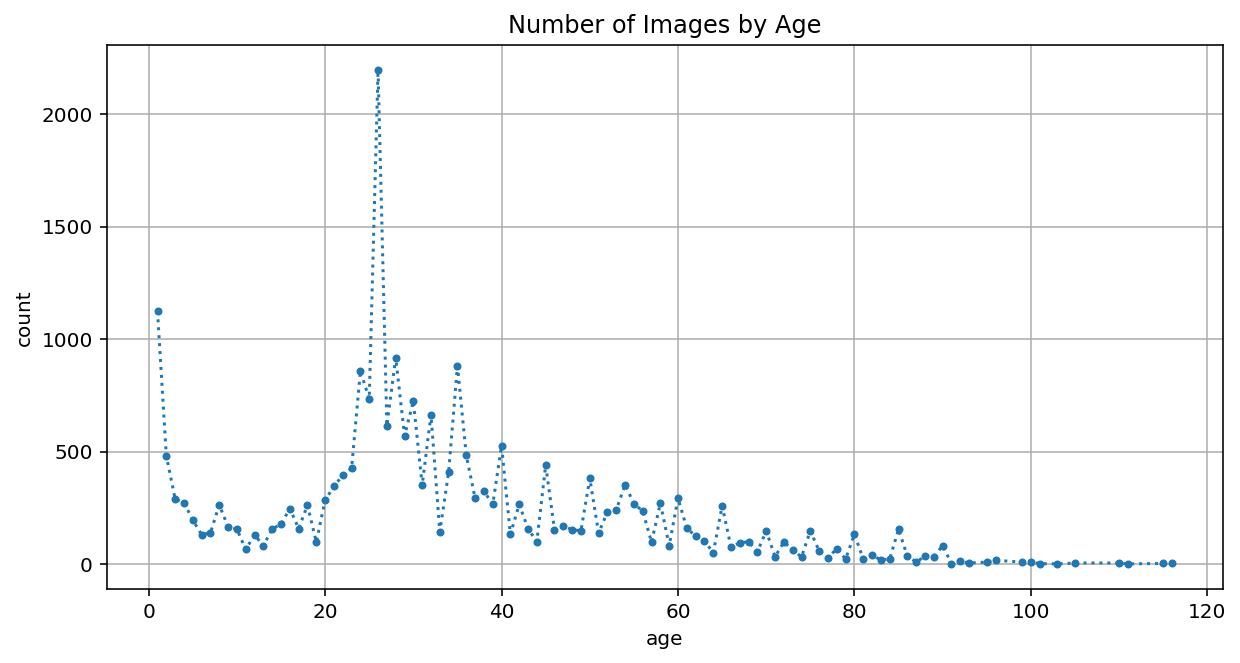

In [11]:
i2age, i2gender, i2race = zip(*[bs_fn.split('_')[:3] for bs_fn in bs_fns])

i2age = [int(o) for o in i2age]


plt.figure(figsize=(10, 5))
plt.plot(*zip(*sorted(Counter(i2age).items())), '.:')
plt.title('Number of Images by Age')
plt.ylabel('count')
plt.xlabel('age')
plt.grid()

In [12]:
o2gender = {'0': 'm', '1': 'f'}
i2gender = [o2gender[o] for o in i2gender]

Counter(i2gender)

Counter({'f': 11314, 'm': 12391})

In [13]:
o2race = dict(list(enumerate(('White', 'Black', 'Asian', 'Indian', 'Others'))))
i2race = [o2race[int(o)] for o in i2race]

Counter(i2race).most_common()

[('White', 10078),
 ('Black', 4526),
 ('Indian', 3975),
 ('Asian', 3434),
 ('Others', 1692)]

age: 21, gender: f, race: White


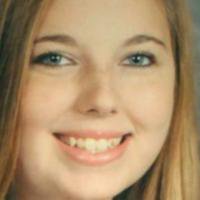

In [14]:
fn = np.random.choice(fns)
i = fn2i[fn]
print(f'age: {i2age[i]}, gender: {i2gender[i]}, race: {i2race[i]}')
open_image(fn)

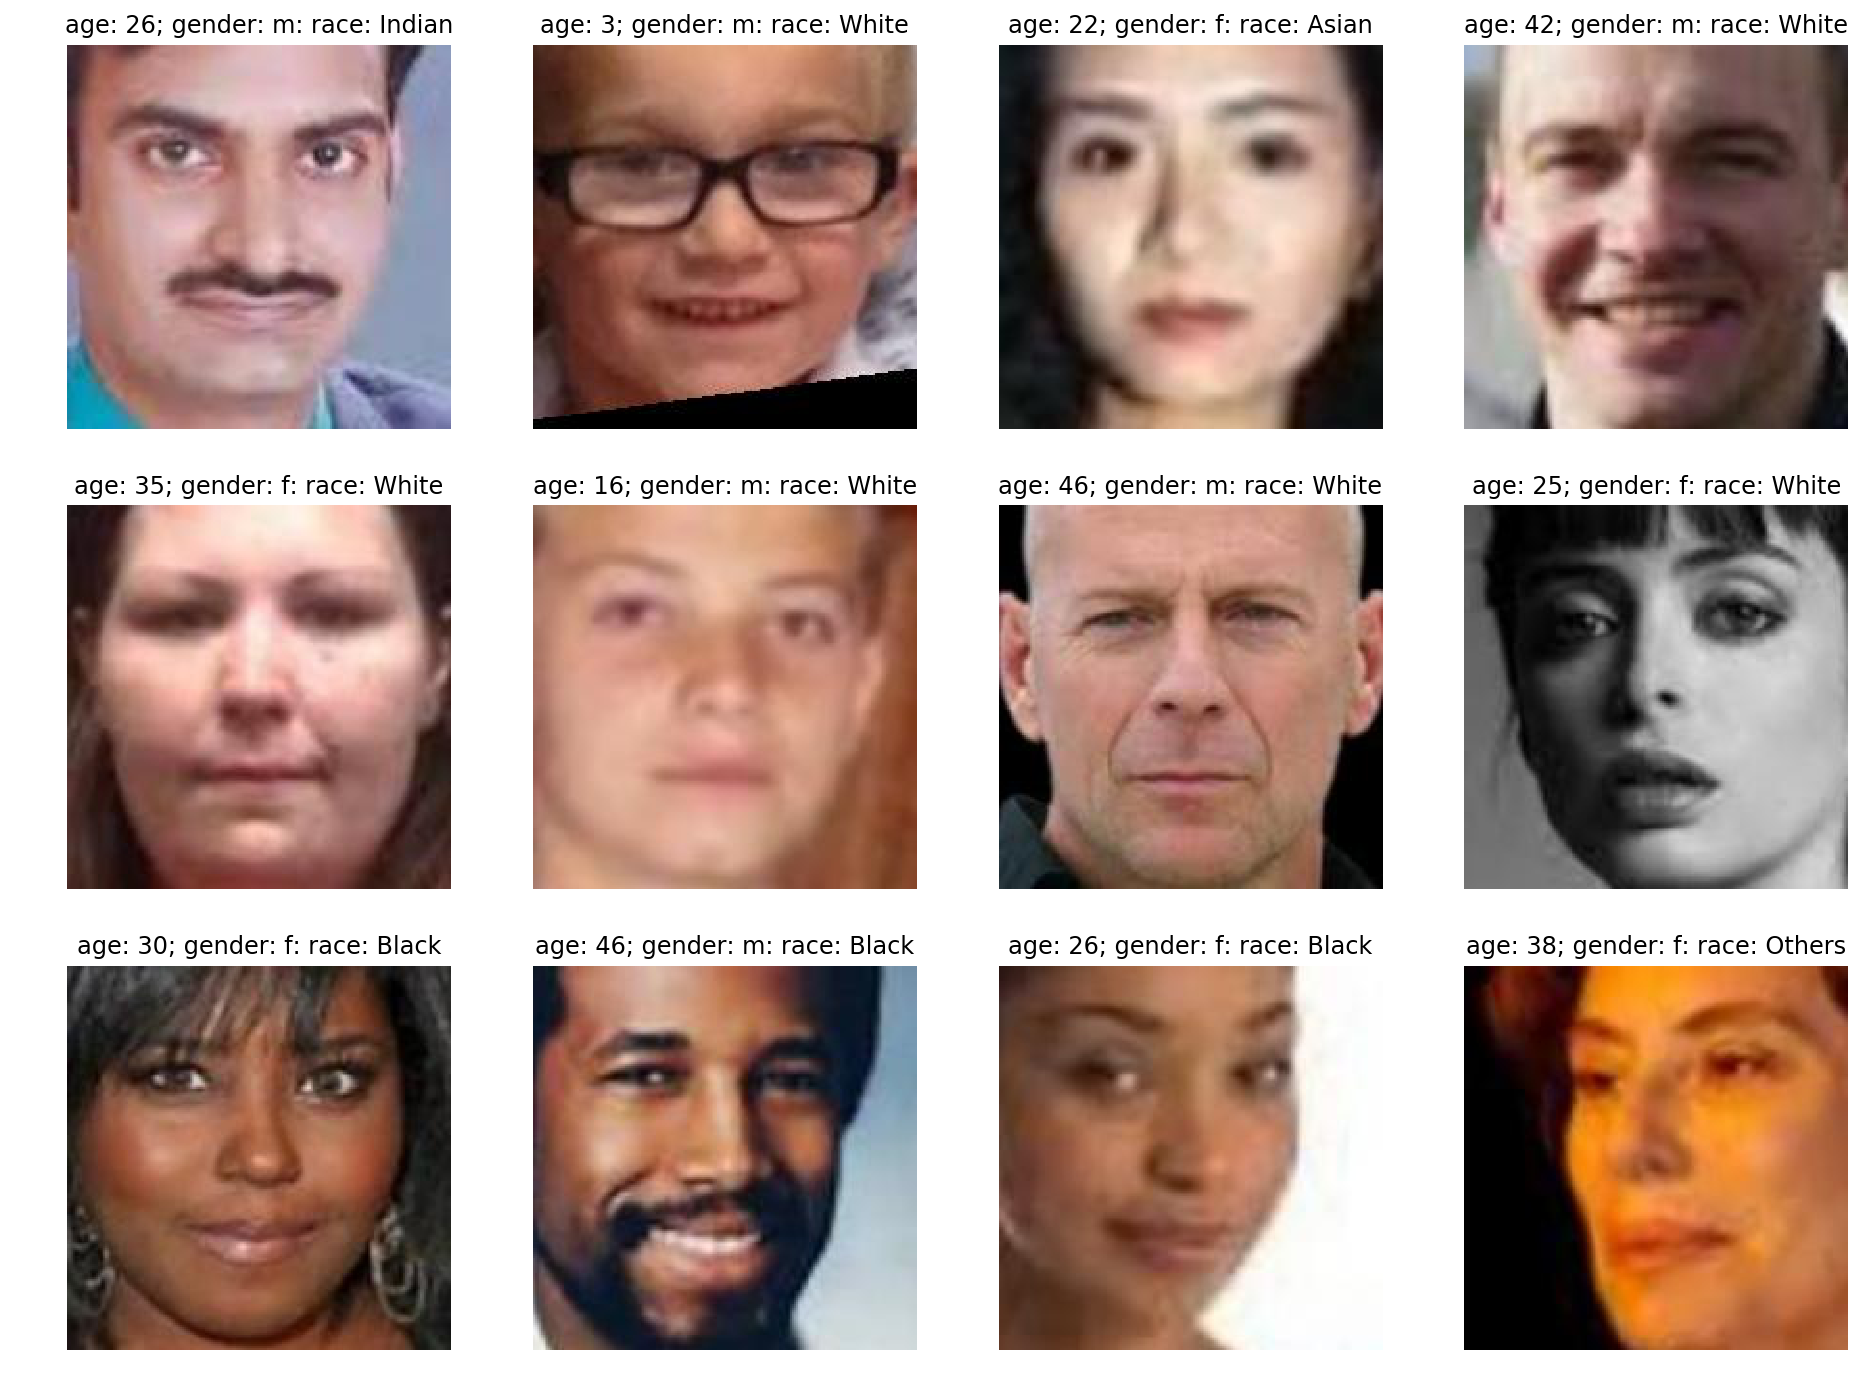

In [15]:
nr, nc = 3, 4
fig, axs = plt.subplots(nrows=nr, ncols=nc, figsize=(4*nc, 4*nr))
fns_sample = np.random.choice(fns, nr*nc)

for j, fn in enumerate(fns_sample):
    i = fn2i[fn]
    show_image(open_image(fn), axs[j//nc, j%nc])
    axs[j//nc, j%nc].set(title=f'age: {i2age[i]}; gender: {i2gender[i]}: race: {i2race[i]}')

In [16]:
gender='m'
ages_gender=[age for i, age in enumerate(i2age) if i2gender[i]==gender]

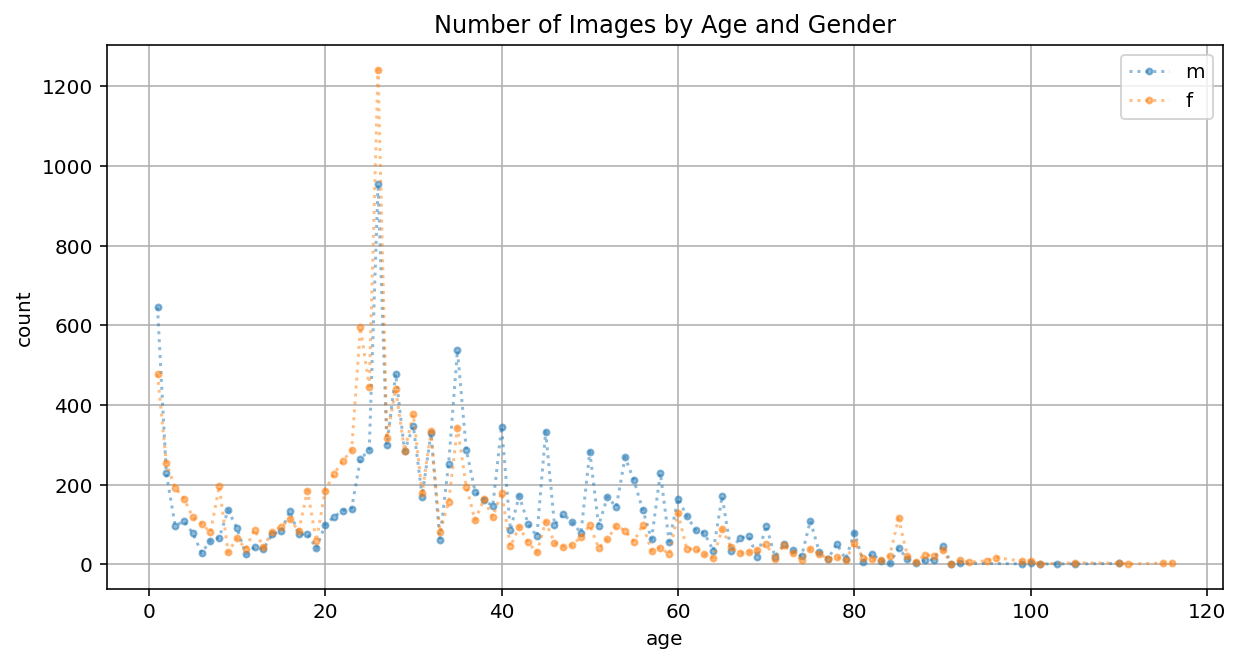

In [17]:
plt.figure(figsize=(10, 5))
for gender in o2gender.values():
    ages_gender=[age for i, age in enumerate(i2age) if i2gender[i]==gender]
    plt.plot(*zip(*sorted(Counter(ages_gender).items())), '.:', label=gender, alpha=.5)
    plt.title('Number of Images by Age and Gender')
    plt.ylabel('count')
    plt.xlabel('age')
    plt.legend()
plt.grid()

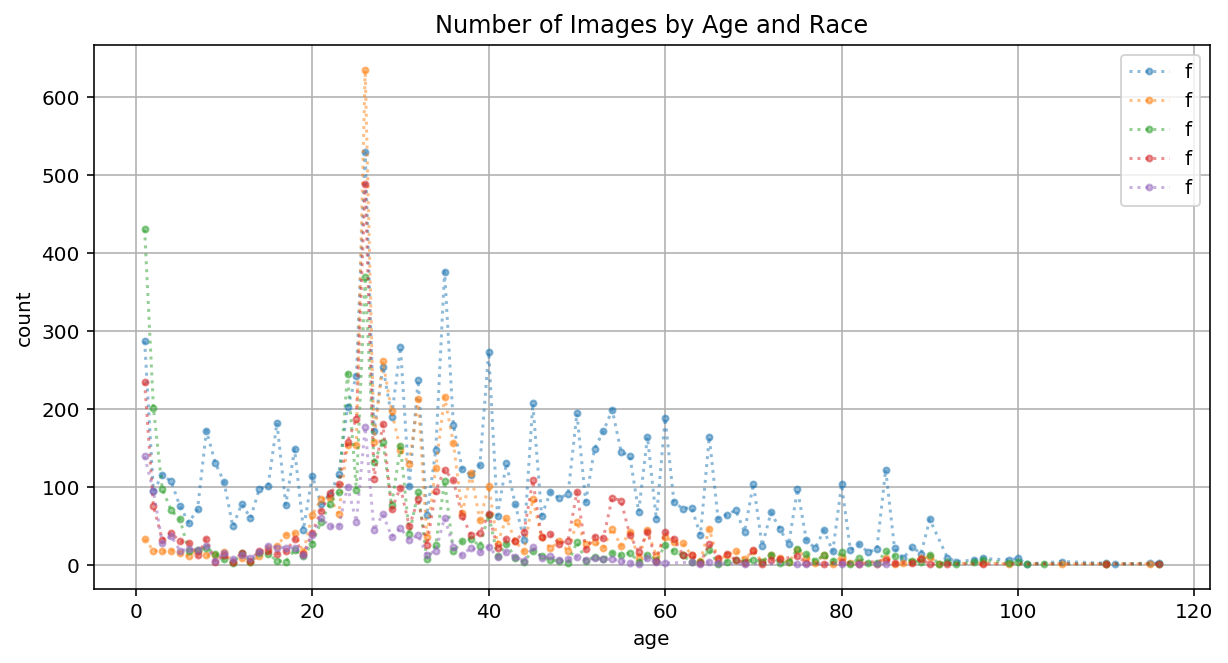

In [18]:
plt.figure(figsize=(10, 5))

for race in o2race.values():
    ages_race=[age for i, age in enumerate(i2age) if i2race[i]==race]
    plt.plot(*zip(*sorted(Counter(ages_race).items())), '.:', label=gender, alpha=.5)
    plt.title('Number of Images by Age and Race')
    plt.ylabel('count')
    plt.xlabel('age')
    plt.legend()
plt.grid()


In [19]:
sorted(Counter(list(zip(i2race, i2gender))). items())

[(('Asian', 'f'), 1859),
 (('Asian', 'm'), 1575),
 (('Black', 'f'), 2208),
 (('Black', 'm'), 2318),
 (('Indian', 'f'), 1714),
 (('Indian', 'm'), 2261),
 (('Others', 'f'), 932),
 (('Others', 'm'), 760),
 (('White', 'f'), 4601),
 (('White', 'm'), 5477)]

## Landmark

In [20]:
list(pdata.glob('Landmark/*'))

[PosixPath('/data/utkface/Landmark/landmark_list_part3.txt'),
 PosixPath('/data/utkface/Landmark/read_face_landmark.m'),
 PosixPath('/data/utkface/Landmark/landmark_list_part2.txt'),
 PosixPath('/data/utkface/Landmark/landmark_list_part1.txt')]

In [292]:
!cat $pdata/Landmark/read_face_landmark.m

%% read face images and landmarks
% Author:   Zhifei Zhang
% Date:     Dec. 28, 2016
% Tested on MATLAB R2015a 
clc; clear; close all

%% load
imgPath = './Aligned&Cropped Faces/';
files = dir(fullfile([imgPath '/*.jpg']));
fid = fopen('./landmark_list.txt');
tline = fgets(fid);
landmark = zeros(1, 68*2);
landmark_list = [];
cnt = 1;
while ischar(tline)
    str = strsplit(tline, ' ');
    filename = str{1};
    for i = 2:137
        landmark(i-1) = str2double(str{i});
    end
    landmark_list(cnt).name = filename;
    landmark_list(cnt).landmark = reshape(landmark, 2, [])';
    cnt = cnt + 1;
    tline = fgets(fid);
end
fclose(fid);
if length(files) ~= length(landmark_list)
    warning('Dismatching of landmark list and image number!')
end

for loop = 1:length(landmark_list)
    file = landmark_list(loop).name;
    try
        img = imread([imgPath '/' file]);
        imshow(img)
        hold on
        landmark = landmark_list(loop).landmark;
        % Around Chin. Ear to Ear
        